In [1]:
using LinearAlgebra
using StaticArrays
using Pkg
using PyCall
using Plots
using Distances
using Statistics
theme(:dark)
using PlotlyJS
# ENV["PYTHON"]="/usr/local/Caskroom/miniconda/base/bin/python"
# Pkg.build("PyCall")
p = pyimport("pymatgen")



HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-17482072945560890891\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16234872204786591524\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-17482072945560890891\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

PyObject <module 'pymatgen' from '/usr/local/Caskroom/miniconda/base/lib/python3.7/site-packages/pymatgen/__init__.py'>

In [10]:
struct tetra
    ge::Array{Float64,1}
    cl1::Array{Float64,1}
    cl2::Array{Float64,1}
    cl3::Array{Float64,1}
end
struct tot_system
    structure
    a::Array{Float64,1}
    b::Array{Float64,1}
    c::Array{Float64,1}
end

In [11]:
icross(b) = copy(Transpose(hcat([cross(Matrix(1.0I, 3, 3)[:,i],b) for i in 1:3]...)));
anchor(tetra) = (tetra.ge+tetra.cl1+tetra.cl2+tetra.cl3)/4
function Mdot(a1,a2)
    #=redefing dot product like numpy for matrix=#
    a1_1=copy(Transpose(a1))'
    return [dot(a1_1[i,:],a2) for i in 1:3]
end

function rot(coords,anc,axis,theta)
    #=rotate coords by theta wrt anc with axis as axis=#
    theta %= 2 * pi
    rm=exp(icross(axis/norm(axis))*theta)
    val=Mdot(rm,(coords-anc))+anc
    return val
    end;

function rot_tetra_test_1(t::tetra,axis::Array{Float64,1},theta)
    #=rotate all atoms in tetra by theta with axis = axis=#
    anc=anchor(t)
    ge=rot(t.ge,anc,axis,theta)
    cl1=rot(t.cl1,anc,axis,theta)
    cl2=rot(t.cl2,anc,axis,theta)
    cl3=rot(t.cl3,anc,axis,theta)
    return tetra(ge,cl1,cl2,cl3)
    end;

function pbc_test(tot_system,img,sc=[2,1,1]) 
    # PBC condition for NN
    pos=[0,0,0]
    add=[0,0,0]
    if img[1]<=sc[1] && img[1]>0
        pos[1]=img[1]
    end
    if img[2]<=sc[2] && img[2]>0
        pos[2]=img[2]
    end
    if img[3]<=sc[3] && img[3]>0
        pos[3]=img[3]
    end
    
    if img[1]<=0
        pos[1]=sc[1]
        add-=tot_system.a
    end
    if img[2]<=0
        pos[2]=sc[2]
        add-=tot_system.b
    end
    if img[3]<=0
        pos[3]=sc[3]
        add-=tot_system.c
    end
    
    if img[1]>sc[1]
        pos[1]=-sc[1]+img[1]
        add+=tot_system.a
    end
    if img[2]>sc[2]
        pos[2]=-sc[2]+img[2]
        add+=tot_system.b
    end
    if img[3]>sc[3]
        pos[3]=-sc[3]+img[3]
        add+=tot_system.c
    end
    return pos,add
end

pbc_test (generic function with 2 methods)

In [12]:
function get_nn_1(tot_system,pos,size=[2,1,1])
    #= Get first 6 Nearest neibghors to Ge atoms which are Chlorine with PBC=#
    system=tot_system.structure
    tmp=Array{Float64, 1}[]
    for i in -1:1
        for j in -1:1
            for k in -1:1
                index,add=pbc_test(tot_system,pos+[i,j,k],size)
                push!(tmp,system[index[1],index[2],index[3]].cl1+add)
                push!(tmp,system[index[1],index[2],index[3]].cl2+add)
                push!(tmp,system[index[1],index[2],index[3]].cl3+add)
            end
        end
    end
    return tmp
    end;

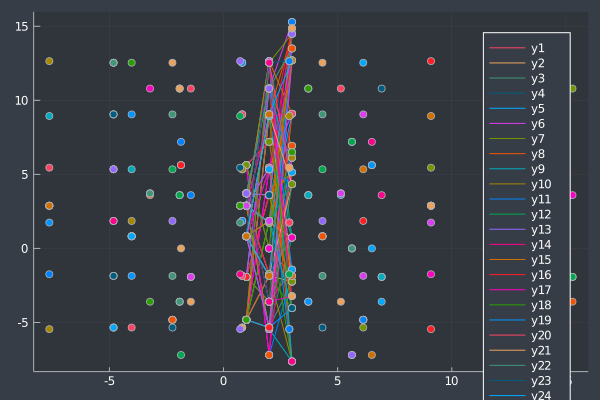

In [136]:

for i in get_nn_1(system,[1,1,1])
    p=scatter!([i[3]],[i[1]],label="")
end
display(p)

In [52]:
struc1.lattice.matrix.tolist()

3×3 Array{Float64,2}:
  5.63774      0.0      -1.78766
 -4.40654e-16  7.19642   4.40654e-16
  0.0          0.0       8.36143

In [5]:
function get_mean_var(system,pos,return_type="var")
    # Get the mean or variance of a position of lattice  wrt bond distance#
    sys=system[pos[1],pos[2],pos[3]]
    distance_1=colwise(Euclidean(), sys.ge, copy(hcat(get_nn_1(system,pos,n)...)))
    nn=sort(distance_1)[1:6]
    var_sys=var(nn)
    mean_sys=mean(nn)
    if return_type=="mean"
        return mean_sys
    else
        return var_sys
    end
    end;

In [6]:
function make_symstem(n=1)
    cssii2=p.Structure.from_file("dipoles.cif")
    struc1=cssii2.copy()
    struc1.make_supercell([[n,0,0],[0,n,0],[0,0,n]])
    dist=cssii2.get_distance(3,5)+.1
    positions=Array{Int64, 1}[]
    for i in struc1
        if i.species_string=="Ge"
            push!(positions,struc1.get_neighbor_list(dist,[i])[2])
        end
    end
    system=Array{tetra,3}(undef,2*n,n,n);
    cnt=1
    for i in 1:2*n
        for j in 1:n
            for k in 1:n
                ge=get(struc1,reverse(positions[cnt])[1]).coords
                cl1=get(struc1,reverse(positions[cnt])[2]).coords
                cl2=get(struc1,reverse(positions[cnt])[3]).coords
                cl3=get(struc1,reverse(positions[cnt])[4]).coords
                system[i,j,k]=tetra(ge,cl1,cl2,cl3)    
                cnt+=1
            end
        end
    end
    
    return tot_system(system,struc1.lattice.matrix.tolist()'[1:3],
                        struc1.lattice.matrix.tolist()'[4:6],
                        struc1.lattice.matrix.tolist()'[7:9])
    end;

In [7]:
n=1
system=make_symstem(n);

In [8]:
cssii2=p.Structure.from_file("dipoles.cif")
struc1=cssii2.copy()
struc1.make_supercell([[n,0,0],[0,n,0],[0,0,n]])
struc1.lattice.matrix.tolist()

3×3 Array{Float64,2}:
  5.63774      0.0      -1.78766
 -4.40654e-16  7.19642   4.40654e-16
  0.0          0.0       8.36143

In [9]:
struc1.lattice.matrix.tolist()'[7:9]

3-element Array{Float64,1}:
 0.0
 0.0
 8.36143

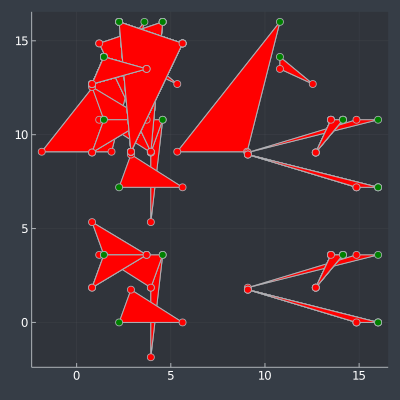

In [33]:
system_test=copy(system.structure)
pos_1=[1,1,1]
axis=[0,0,1.]
theta=pi*0
n1=1
n2=3

system_test[pos_1[1],pos_1[2],pos_1[3]]=
        rot_tetra_test_1(system.structure[pos_1[1],pos_1[2],pos_1[3]],axis,theta);
for i in 0:n
    for j in 0:n
    index,add=pbc_test(system,pos_1+[i,j,1])
    x=[system_test[index[1],index[2],index[3]].ge[n1]+add[n1]
            ,system_test[index[1],index[2],index[3]].cl1[n1]+add[n1]
            ,system_test[index[1],index[2],index[3]].cl3[n1]+add[n1]
            ,system_test[index[1],index[2],index[3]].ge[n1]+add[n1]]
        
    y=[system_test[index[1],index[2],index[3]].ge[n2]+add[n2]
            ,system_test[index[1],index[2],index[3]].cl1[n2]+add[n2]
            ,system_test[index[1],index[2],index[3]].cl3[n2]+add[n2]
            ,system_test[index[1],index[2],index[3]].ge[n2]+add[n2]]
    plt=plot!(x,y,color="grey",label="")
    plot!(Plots.Shape(x,y),label="",color="red")
    scatter!(plt,x[2:3],y[2:3],color="red",label="")
    scatter!(plt,[x[1]],[y[1]],color="green",label="")
    end
end
plot!(size=(400,400))

In [17]:
system

1×1×1 Array{tetra,3}:
[:, :, 1] =
 tetra([2.25509968459519, 0.0, 7.64634058580978], [2.8836394973360293, 1.7449591359199996, 0.7297163349355686], [3.695648123994288, 0.0, 3.6262283283907526], [5.624751413175385, 0.0, 6.498724597737304])